# Tutorial: Time Series Analysis with Pandas

In this tutorial, we will learn about the powerful time series tools in the pandas library.

Originally developed for financial time series such as daily stock market prices, the robust and flexible data structures in pandas can be applied to time series data in any domain, including business, science, engineering, public health, and many others. With these tools you can easily organize, transform, analyze, and visualize your data at any level of granularity — examining details during specific time periods of interest, and zooming out to explore variations on different time scales, such as monthly or annual aggregations, recurring patterns, and long-term trends.

In the broadest definition, a time series is any data set where the values are measured at different points in time. Many time series are uniformly spaced at a specific frequency, for example, hourly weather measurements, daily counts of web site visits, or monthly sales totals. Time series can also be irregularly spaced and sporadic, for example, timestamped data in a computer system’s event log or a history of 911 emergency calls. Pandas time series tools apply equally well to either type of time series.

This tutorial will focus mainly on the data wrangling and visualization aspects of time series analysis. Working with a time series of energy data, we’ll see how techniques such as time-based indexing, resampling, and rolling windows can help us explore variations in electricity demand and renewable energy supply over time. We’ll be covering the following topics:

- The data set: Open Power Systems Data
- Time series data structures
- Time-based indexing
- Visualizing time series data
- Seasonality
- Frequencies
- Resampling
- Rolling windows
- Trends
We’ll be using Python and its data manipulation and visualization libraries: pandas, matplotlib, and seaborn. To get the most out of this tutorial, you’ll want to be familiar with the basics of pandas and matplotlib.

# The dataset: Open Power Systems Data
In this tutorial, we’ll be working with daily time series of Open Power System Data (OPSD) for Germany, which has been rapidly expanding its renewable energy production in recent years. The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. You can download the data [here](https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv).

Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:

- `Date` — The date (yyyy-mm-dd format)
- `Consumption` — Electricity consumption in GWh
- `Wind` — Wind power production in GWh
- `Solar` — Solar power production in GWh
- `Wind+Solar` — Sum of wind and solar power production in GWh

We will explore how electricity consumption and production in Germany have varied over time, using pandas time series tools to answer questions such as:

- When is electricity consumption typically highest and lowest?
- How do wind and solar power production vary with seasons of the year?
- What are the long-term trends in electricity consumption, solar power, and wind power?
- How do wind and solar power production compare with electricity consumption, and how has this ratio changed over time?

# Time series data structures
Before we dive into the OPSD data, let’s briefly introduce the main pandas data structures for working with dates and times. In pandas, a single point in time is represented as a **Timestamp**. We can use the `to_datetime()` function to create Timestamps from strings in a wide variety of date/time formats. Let’s import pandas and convert a few dates and times to Timestamps.

In [2]:
import pandas as pd
pd.to_datetime('2018-01-15 3:45pm')

Timestamp('2018-01-15 15:45:00')

In [3]:
pd.to_datetime('7/8/1952')

Timestamp('1952-07-08 00:00:00')

As we can see, `to_datetime()` automatically infers a date/time format based on the input. In the example above, the ambiguous date `'7/8/1952'` is assumed to be month/day/year and is interpreted as July 8, 1952. Alternatively, we can use the `dayfirst` parameter to tell pandas to interpret the date as August 7, 1952.

In [4]:
pd.to_datetime('7/8/1952', dayfirst=True)

Timestamp('1952-08-07 00:00:00')

If we supply a list or array of strings as input to `to_datetime()`, it returns a sequence of date/time values in a **DatetimeIndex** object, which is the core data structure that powers much of pandas time series functionality.

In [5]:
pd.to_datetime(['2018-01-05', '7/8/1952', 'Oct 10, 1995'])

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

In the DatetimeIndex above, the data type `datetime64[ns]` indicates that the underlying data is stored as 64-bit integers, in units of nanoseconds (ns). This data structure allows pandas to compactly store large sequences of date/time values and efficiently perform vectorized operations using NumPy datetime64 arrays.

If we’re dealing with a sequence of strings all in the same date/time format, we can explicitly specify it with the format parameter. For very large data sets, this can greatly speed up the performance of `to_datetime()` compared to the default behavior, where the format is inferred separately for each individual string. Any of the format codes from the `strftime()` and `strptime()` functions in Python’s built-in datetime module can be used. The example below uses the format codes `%m` (numeric month), `%d` (day of month), and `%y` (2-digit year) to specify the format.

In [6]:
pd.to_datetime(['2/25/10', '8/6/17', '12/15/12'], format='%m/%d/%y')

DatetimeIndex(['2010-02-25', '2017-08-06', '2012-12-15'], dtype='datetime64[ns]', freq=None)

In addition to Timestamp and DatetimeIndex objects representing individual points in time, pandas also includes data structures representing durations (e.g., 125 seconds) and periods (e.g., the month of November 2018). For more about these data structures, there is a nice summary here. In this tutorial we will use DatetimeIndexes, the most common data structure for pandas time series.

# Creating a time series DataFrame
To work with time series data in pandas, we use a DatetimeIndex as the index for our DataFrame (or Series). Let’s see how to do this with our OPSD data set. First, we use the `read_csv()` function to read the data into a DataFrame, and then display its shape.

In [7]:
opsd_daily = pd.read_csv('datasets\Time Series\opsd_germany_daily.csv')
opsd_daily.shape

(4383, 5)

The DataFrame has 4383 rows, covering the period from January 1, 2006 through December 31, 2017. To see what the data looks like, let’s use the `head()` and `tail()` methods to display the first three and last three rows.

In [8]:
opsd_daily.head(3)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN


In [9]:
opsd_daily.tail(3)

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


Next, let’s check out the data types of each column.

In [10]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

Date columns must be in a datetime64 format.

In [11]:
opsd_daily['Date'] = pd.to_datetime(opsd_daily['Date'])

In [12]:
opsd_daily.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

Now that the `Date` column is the correct data type, let’s set it as the DataFrame’s index.

In [13]:
opsd_daily = opsd_daily.set_index('Date')
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [14]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

Alternatively, we can consolidate the above steps into a single line, using the `index_col` and `parse_dates` parameters of the `read_csv()` function. This is often a useful shortcut.

In [15]:
opsd_daily = pd.read_csv('datasets\Time Series\opsd_germany_daily.csv', index_col=0, parse_dates=True)

Now that our DataFrame’s index is a DatetimeIndex, we can use all of pandas’ powerful time-based indexing to wrangle and analyze our data, as we shall see in the following sections.

Another useful aspect of the DatetimeIndex is that the individual date/time components are all available as attributes such as `year`, `month`, `day`, and so on. Let’s add a few more columns to `opsd_daily`, containing the year, month, and weekday name.

In [16]:
# Add columns with year, month, and weekday name
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.day_name()
# Display a random sampling of 5 rows
opsd_daily.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


# Time-based indexing
One of the most powerful and convenient features of pandas time series is time-based indexing — using dates and times to intuitively organize and access our data. With time-based indexing, we can use date/time formatted strings to select data in our DataFrame with the `loc` accessor. The indexing works similar to standard label-based indexing with loc, but with a few additional features.

For example, we can select data for a single day using a string such as `'2017-08-10'`.

In [17]:
opsd_daily.loc['2017-08-10']

Consumption     1351.491
Wind             100.274
Solar              71.16
Wind+Solar       171.434
Year                2017
Month                  8
Weekday Name    Thursday
Name: 2017-08-10 00:00:00, dtype: object

We can also select a slice of days, such as `'2014-01-20':'2014-01-22'`. As with regular label-based indexing with `loc`, the slice is inclusive of both endpoints.

In [18]:
opsd_daily.loc['2014-01-20':'2014-01-22']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2014-01-20,1590.687,78.647,6.371,85.018,2014,1,Monday
2014-01-21,1624.806,15.643,5.835,21.478,2014,1,Tuesday
2014-01-22,1625.155,60.259,11.992,72.251,2014,1,Wednesday


Another very handy feature of pandas time series is partial-string indexing, where we can select all date/times which partially match a given string. For example, we can select the entire year 2006 with `opsd_daily.loc['2006']`, or the entire month of February 2012 with `opsd_daily.loc['2012-02']`.

In [19]:
opsd_daily.loc['2012-02']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2012-02-01,1511.866,199.607,43.502,243.109,2012,2,Wednesday
2012-02-02,1563.407,73.469,44.675,118.144,2012,2,Thursday
2012-02-03,1563.631,36.352,46.510,82.862,2012,2,Friday
2012-02-04,1372.614,20.551,45.225,65.776,2012,2,Saturday
2012-02-05,1279.432,55.522,54.572,110.094,2012,2,Sunday
2012-02-06,1574.766,34.896,55.389,90.285,2012,2,Monday
2012-02-07,1615.078,100.312,19.867,120.179,2012,2,Tuesday
2012-02-08,1613.774,93.763,36.930,130.693,2012,2,Wednesday
2012-02-09,1591.532,132.219,19.042,151.261,2012,2,Thursday


# Visualizing time series data
With pandas and matplotlib, we can easily visualize our time series data. In this section, we’ll cover a few examples and some useful customizations for our time series plots. First, let’s import matplotlib.

In [20]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

We’ll use seaborn styling for our plots, and let’s adjust the default figure size to an appropriate shape for time series plots.

In [21]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

Let’s create a line plot of the full time series of Germany’s daily electricity consumption, using the DataFrame’s `plot()` method.

<AxesSubplot:xlabel='Date'>

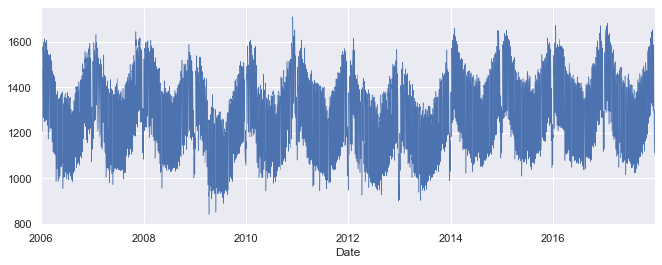

In [22]:
opsd_daily['Consumption'].plot(linewidth=0.5)

We can see that the `plot()` method has chosen pretty good tick locations (every two years) and labels (the years) for the x-axis, which is helpful. However, with so many data points, the line plot is crowded and hard to read. Let’s plot the data as dots instead, and also look at the Solar and Wind time series.

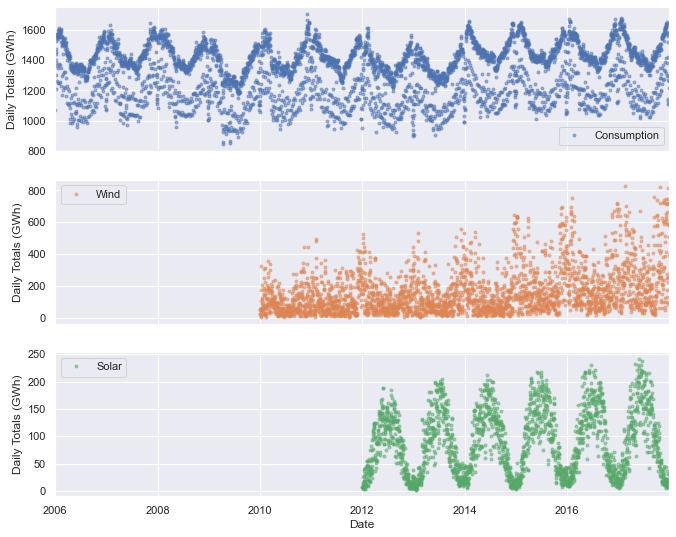

In [24]:
cols_plot = ['Consumption', 'Wind', 'Solar']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

We can already see some interesting patterns emerge:

- Electricity consumption is highest in winter, presumably due to electric heating and increased lighting usage, and lowest in summer.
- Electricity consumption appears to split into two clusters — one with oscillations centered roughly around 1400 GWh, and another with fewer and more scattered data points, centered roughly around 1150 GWh. We might guess that these clusters correspond with weekdays and weekends, and we will investigate this further shortly.
- Solar power production is highest in summer, when sunlight is most abundant, and lowest in winter.
Wind power production is highest in winter, presumably due to stronger winds and more frequent storms, and lowest in summer.

There appears to be a strong increasing trend in wind power production over the years.
All three time series clearly exhibit periodicity—often referred to as seasonality in time series analysis—in which a pattern repeats again and again at regular time intervals. The Consumption, Solar, and Wind time series oscillate between high and low values on a yearly time scale, corresponding with the seasonal changes in weather over the year. However, seasonality in general does not have to correspond with the meteorological seasons. For example, retail sales data often exhibits yearly seasonality with increased sales in November and December, leading up to the holidays.

Seasonality can also occur on other time scales. The plot above suggests there may be some weekly seasonality in Germany’s electricity consumption, corresponding with weekdays and weekends. Let’s plot the time series in a single year to investigate further.

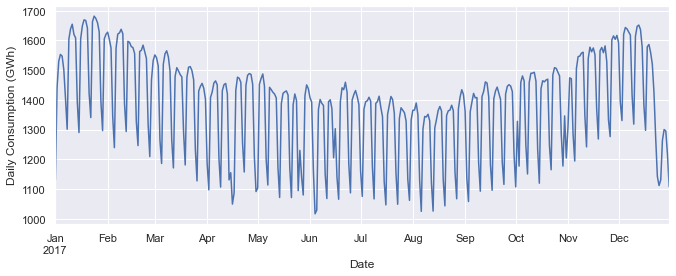

In [25]:
ax = opsd_daily.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

Now we can clearly see the weekly oscillations. Another interesting feature that becomes apparent at this level of granularity is the drastic decrease in electricity consumption in early January and late December, during the holidays.

Let’s zoom in further and look at just January and February.

Text(0, 0.5, 'Daily Consumption (GWh)')

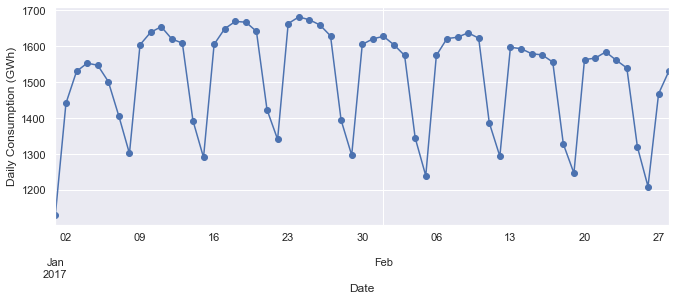

In [26]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')

As we suspected, consumption is highest on weekdays and lowest on weekends.

# Customizing time series plots
To better visualize the weekly seasonality in electricity consumption in the plot above, it would be nice to have vertical gridlines on a weekly time scale (instead of on the first day of each month). We can customize our plot with [matplotlib.dates](https://matplotlib.org/stable/api/dates_api.html), so let’s import that module.

In [27]:
import matplotlib.dates as mdates

Because date/time ticks are handled a bit differently in `matplotlib.dates` compared with the DataFrame’s `plot()` method, let’s create the plot directly in matplotlib. Then we use `mdates.WeekdayLocator()` and `mdates.MONDAY` to set the x-axis ticks to the first Monday of each week. We also use `mdates.DateFormatter()` to improve the formatting of the tick labels, using the format codes we saw earlier.

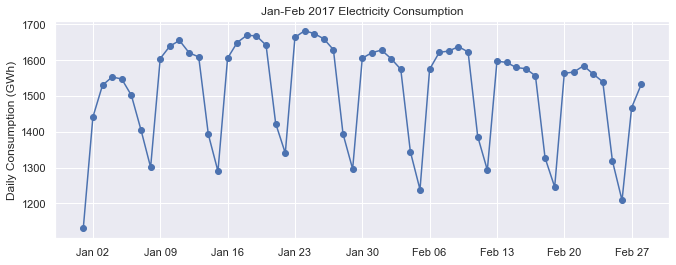

In [28]:
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

Now we have vertical gridlines and nicely formatted tick labels on each Monday, so we can easily tell which days are weekdays and weekends.

There are many other ways to visualize time series, depending on what patterns you’re trying to explore — scatter plots, heatmaps, histograms, and so on. We’ll see other visualization examples in the following sections, including visualizations of time series data that has been transformed in some way, such as aggregated or smoothed data.

# Seasonality
Next, let’s further explore the seasonality of our data with box plots, using seaborn’s `boxplot()` function to group the data by different time periods and display the distributions for each group. We’ll first group the data by month, to visualize yearly seasonality.

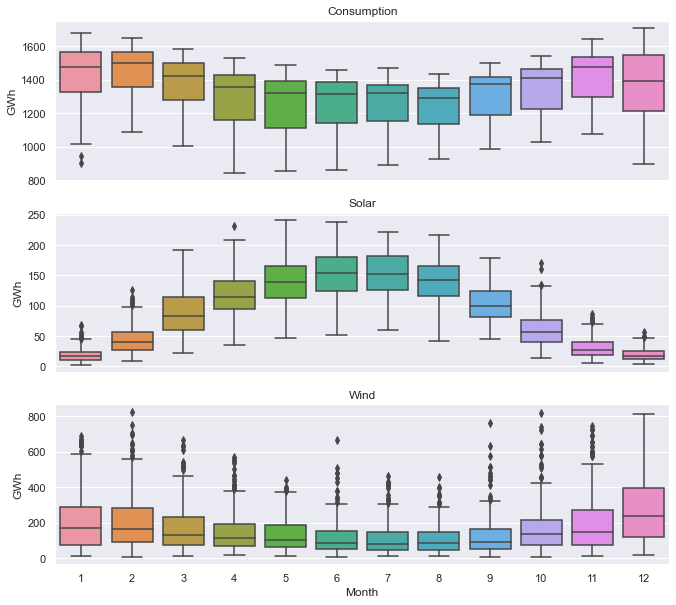

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
    sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
    ax.set_ylabel('GWh')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

These box plots confirm the yearly seasonality that we saw in earlier plots and provide some additional insights:
- Although electricity consumption is generally higher in winter and lower in summer, the median and lower two quartiles are lower in December and January compared to November and February, likely due to businesses being closed over the holidays. We saw this in the time series for the year 2017, and the box plot confirms that this is consistent pattern throughout the years.
- While solar and wind power production both exhibit a yearly seasonality, the wind power distributions have many more outliers, reflecting the effects of occasional extreme wind speeds associated with storms and other transient weather conditions.

Next, let’s group the electricity consumption time series by day of the week, to explore weekly seasonality.

<AxesSubplot:xlabel='Weekday Name', ylabel='Consumption'>

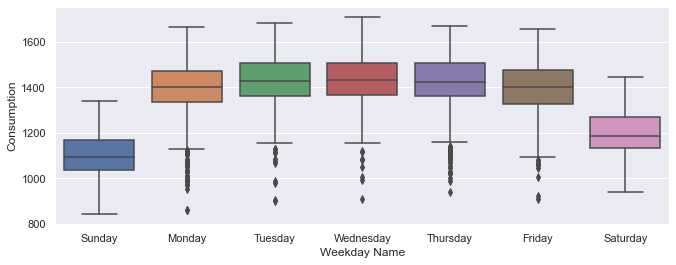

In [31]:
sns.boxplot(data=opsd_daily, x='Weekday Name', y='Consumption')

As expected, electricity consumption is significantly higher on weekdays than on weekends. The low outliers on weekdays are presumably during holidays.

This section has provided a brief introduction to time series seasonality. As we will see later, applying a rolling window to the data can also help to visualize seasonality on different time scales. Other techniques for analyzing seasonality include autocorrelation plots, which plot the correlation coefficients of the time series with itself at different time lags.

Time series with strong seasonality can often be well represented with models that decompose the signal into seasonality and a long-term trend, and these models can be used to forecast future values of the time series. A simple example of such a model is classical seasonal decomposition, as demonstrated in this tutorial. A more sophisticated example is as Facebook’s Prophet model, which uses curve fitting to decompose the time series, taking into account seasonality on multiple time scales, holiday effects, abrupt changepoints, and long-term trends, as demonstrated in this tutorial.

# Frequencies
When the data points of a time series are uniformly spaced in time (e.g., hourly, daily, monthly, etc.), the time series can be associated with a frequency in pandas. For example, let’s use the `date_range()` function to create a sequence of uniformly spaced dates from `1998-03-10` through `1998-03-15` at daily frequency.

In [32]:
pd.date_range('1998-03-10', '1998-03-15', freq='D')

DatetimeIndex(['1998-03-10', '1998-03-11', '1998-03-12', '1998-03-13',
               '1998-03-14', '1998-03-15'],
              dtype='datetime64[ns]', freq='D')

The resulting DatetimeIndex has an attribute freq with a value of `'D'`, indicating daily frequency. Available frequencies in pandas include hourly (`'H'`), calendar daily (`'D'`), business daily (`'B'`), weekly (`'W'`), monthly (`'M'`), quarterly ('Q'), annual ('A'), and many others. Frequencies can also be specified as multiples of any of the base frequencies, for example `'5D'` for every five days.

As another example, let’s create a date range at hourly frequency, specifying the start date and number of periods, instead of the start date and end date.

In [33]:
pd.date_range('2004-09-20', periods=8, freq='H')

DatetimeIndex(['2004-09-20 00:00:00', '2004-09-20 01:00:00',
               '2004-09-20 02:00:00', '2004-09-20 03:00:00',
               '2004-09-20 04:00:00', '2004-09-20 05:00:00',
               '2004-09-20 06:00:00', '2004-09-20 07:00:00'],
              dtype='datetime64[ns]', freq='H')

Now let’s take another look at the DatetimeIndex of our opsd_daily time series.

In [34]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

We can see that it has no frequency (`freq=None`). This makes sense, since the index was created from a sequence of dates in our CSV file, without explicitly specifying any frequency for the time series.
If we know that our data should be at a specific frequency, we can use the DataFrame’s `asfreq()` method to assign a frequency. If any date/times are missing in the data, new rows will be added for those date/times, which are either empty (`NaN`), or filled according to a specified data filling method such as forward filling or interpolation.

To see how this works, let’s create a new DataFrame which contains only the `Consumption` data for Feb 3, 6, and 8, 2013.

In [35]:
# To select an arbitrary sequence of date/time values from a pandas time series,
# we need to use a DatetimeIndex, rather than simply a list of date/time strings
times_sample = pd.to_datetime(['2013-02-03', '2013-02-06', '2013-02-08'])
# Select the specified dates and just the Consumption column
consum_sample = opsd_daily.loc[times_sample, ['Consumption']].copy()
consum_sample

,Consumption
Date,
2013-02-03,1109.639
2013-02-06,1451.449
2013-02-08,1433.098


Now we use the `asfreq()` method to convert the DataFrame to daily frequency, with a column for unfilled data, and a column for forward filled data.

In [36]:
# Convert the data to daily frequency, without filling any missings
consum_freq = consum_sample.asfreq('D')
# Create a column with missings forward filled
consum_freq['Consumption - Forward Fill'] = consum_sample.asfreq('D', method='ffill')
consum_freq

,Consumption,Consumption - Forward Fill
Date,,
2013-02-03,1109.639,1109.639
2013-02-04,NaN,1109.639
2013-02-05,NaN,1109.639
2013-02-06,1451.449,1451.449
2013-02-07,NaN,1451.449
2013-02-08,1433.098,1433.098


In the `Consumption` column, we have the original data, with a value of `NaN` for any date that was missing in our `consum_sample` DataFrame. In the `Consumption - Forward Fill` column, the missings have been forward filled, meaning that the last value repeats through the missing rows until the next non-missing value occurs.

If you’re doing any time series analysis which requires uniformly spaced data without any missings, you’ll want to use `asfreq()` to convert your time series to the specified frequency and fill any missings with an appropriate method.

# Resampling
It is often useful to resample our time series data to a lower or higher frequency. Resampling to a lower frequency (**downsampling**) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. The daily OPSD data we’re working with in this tutorial was downsampled from the original hourly time series. Resampling to a higher frequency (**upsampling**) is less common and often involves interpolation or other data filling method — for example, interpolating hourly weather data to 10 minute intervals for input to a scientific model.

We will focus here on downsampling, exploring how it can help us analyze our OPSD data on various time scales. We use the DataFrame’s `resample()` method, which splits the DatetimeIndex into time bins and groups the data by time bin. The `resample()` method returns a `Resampler object`, similar to a pandas `GroupBy object`. We can then apply an aggregation method such as `mean()`, `median()`, `sum()`, etc., to the data group for each time bin.

For example, let’s resample the data to a weekly mean time series.

In [37]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
# Resample to weekly frequency, aggregating with mean
opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


The first row above, labelled `2006-01-01`, contains the mean of all the data contained in the time bin `2006-01-01` through `2006-01-07`. The second row, labelled `2006-01-08`, contains the mean data for the `2006-01-08` through `2006-01-14` time bin, and so on. By default, each row of the downsampled time series is labelled with the right edge of the time bin.

By construction, our weekly time series has 1/7 as many data points as the daily time series. We can confirm this by comparing the number of rows of the two DataFrames.

In [40]:
print(opsd_daily.shape[0])
print(opsd_weekly_mean.shape[0])

4383
627


Let’s plot the daily and weekly Solar time series together over a single six-month period to compare them.

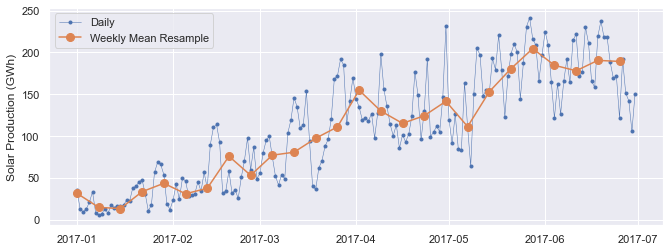

In [42]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Solar Production (GWh)')
ax.legend()

We can see that the weekly mean time series is smoother than the daily time series because higher frequency variability has been averaged out in the resampling.

Now let’s resample the data to monthly frequency, aggregating with sum totals instead of the mean. Unlike aggregating with `mean()`, which sets the output to `NaN` for any period with all missing data, the default behavior of `sum()` will return output of `0` as the sum of missing data. We use the `min_count` parameter to change this behavior.

In [43]:
# Compute the monthly sums, setting the value to NaN for any month which has
# fewer than 28 days of data
opsd_monthly = opsd_daily[data_columns].resample('M').sum(min_count=28)
opsd_monthly.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,45304.704,NaN,NaN,NaN
2006-02-28,41078.993,NaN,NaN,NaN
2006-03-31,43978.124,NaN,NaN,NaN


You might notice that the monthly resampled data is labelled with the end of each month (the right bin edge), whereas the weekly resampled data is labelled with the left bin edge. By default, resampled data is labelled with the right bin edge for monthly, quarterly, and annual frequencies, and with the left bin edge for all other frequencies. This behavior and various other options can be adjusted using the parameters listed in the resample() documentation.

Now let’s explore the monthly time series by plotting the electricity consumption as a line plot, and the wind and solar power production together as a stacked area plot.

Text(0, 0.5, 'Monthly Total (GWh)')

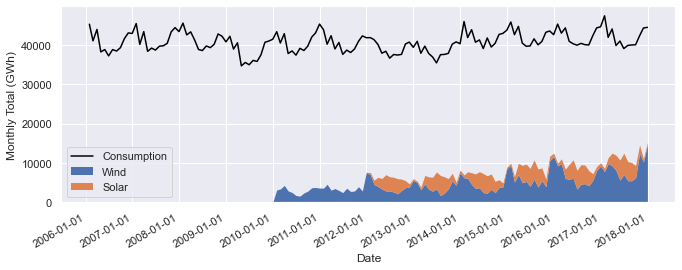

In [44]:
fig, ax = plt.subplots()
ax.plot(opsd_monthly['Consumption'], color='black', label='Consumption')
opsd_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)')

At this monthly time scale, we can clearly see the yearly seasonality in each time series, and it is also evident that electricity consumption has been fairly stable over time, while wind power production has been growing steadily, with wind + solar power comprising an increasing share of the electricity consumed.

Let’s explore this further by resampling to annual frequency and computing the ratio of Wind+Solar to Consumption for each year.

In [45]:
# Compute the annual sums, setting the value to NaN for any year which has
# fewer than 360 days of data
opsd_annual = opsd_daily[data_columns].resample('A').sum(min_count=360)
# The default index of the resampled DataFrame is the last day of each year,
# ('2006-12-31', '2007-12-31', etc.) so to make life easier, set the index
# to the year component
opsd_annual = opsd_annual.set_index(opsd_annual.index.year)
opsd_annual.index.name = 'Year'
# Compute the ratio of Wind+Solar to Consumption
opsd_annual['Wind+Solar/Consumption'] = opsd_annual['Wind+Solar'] / opsd_annual['Consumption']
opsd_annual.tail(3)

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption
Year,,,,,
2015,505264.56300,77468.994,34907.138,112376.132,0.222410
2016,505927.35400,77008.126,34562.824,111570.950,0.220528
2017,504736.36939,102667.365,35882.643,138550.008,0.274500


Finally, let’s plot the wind + solar share of annual electricity consumption as a bar chart.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '2012'),
  Text(1, 0, '2013'),
  Text(2, 0, '2014'),
  Text(3, 0, '2015'),
  Text(4, 0, '2016'),
  Text(5, 0, '2017')])

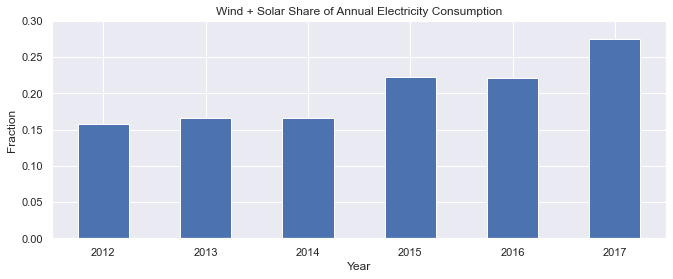

In [46]:
# Plot from 2012 onwards, because there is no solar production data in earlier years
ax = opsd_annual.loc[2012:, 'Wind+Solar/Consumption'].plot.bar(color='C0')
ax.set_ylabel('Fraction')
ax.set_ylim(0, 0.3)
ax.set_title('Wind + Solar Share of Annual Electricity Consumption')
plt.xticks(rotation=0)

We can see that wind + solar production as a share of annual electricity consumption has been increasing from about 15% in 2012 to about 27% in 2017.

# Rolling windows
**Rolling window** operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as `mean()`, `median()`, `sum()`, etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.

By default, all data points within a window are equally weighted in the aggregation, but this can be changed by specifying window types such as Gaussian, triangular, and others. We’ll stick with the standard equally weighted window here.

Let’s use the `rolling()` method to compute the 7-day rolling mean of our daily data. We use the `center=True` argument to label each window at its midpoint, so the rolling windows are:

- 2006-01-01 to 2006-01-07 — labelled as 2006-01-04
- 2006-01-02 to 2006-01-08 — labelled as 2006-01-05
- 2006-01-03 to 2006-01-09 — labelled as 2006-01-06
- and so on…

In [47]:
# Compute the centered 7-day rolling mean
opsd_7d = opsd_daily[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


We can see that the first non-missing rolling mean value is on 2006-01-04, because this is the midpoint of the first rolling window.

To visualize the differences between rolling mean and resampling, let’s update our earlier plot of January-June 2017 solar power production to include the 7-day rolling mean along with the weekly mean resampled time series and the original daily data.

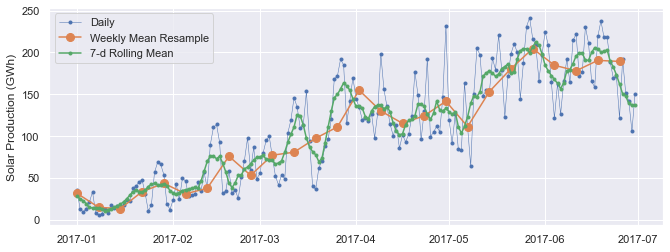

In [49]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d.loc[start:end, 'Solar'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend()

We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

# Trends
Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean tends to smooth a time series by averaging out variations at frequencies much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let’s look at rolling means on those two time scales.

We’ve already computed 7-day rolling means, so now let’s compute the 365-day rolling mean of our OPSD data.

In [50]:
# The min_periods=360 argument accounts for a few isolated missing days in the
# wind and solar production time series
opsd_365d = opsd_daily[data_columns].rolling(window=365, center=True, min_periods=360).mean()

Let’s plot the 7-day and 365-day rolling mean electricity consumption, along with the daily time series.

Text(0.5, 1.0, 'Trends in Electricity Consumption')

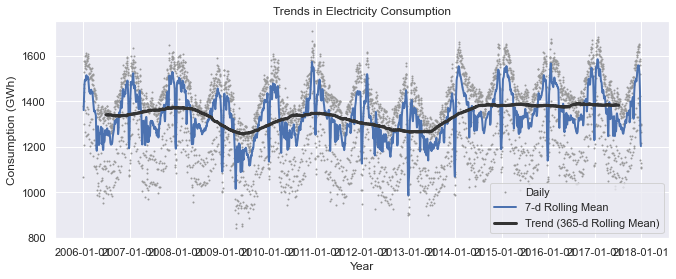

In [51]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(opsd_daily['Consumption'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(opsd_7d['Consumption'], linewidth=2, label='7-d Rolling Mean')
ax.plot(opsd_365d['Consumption'], color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption')

We can see that the 7-day rolling mean has smoothed out all the weekly seasonality, while preserving the yearly seasonality. The 7-day rolling mean reveals that while electricity consumption is typically higher in winter and lower in summer, there is a dramatic decrease for a few weeks every winter at the end of December and beginning of January, during the holidays.

Looking at the 365-day rolling mean time series, we can see that the long-term trend in electricity consumption is pretty flat, with a couple of periods of anomalously low consumption around 2009 and 2012-2013.

Now let’s look at trends in wind and solar production.

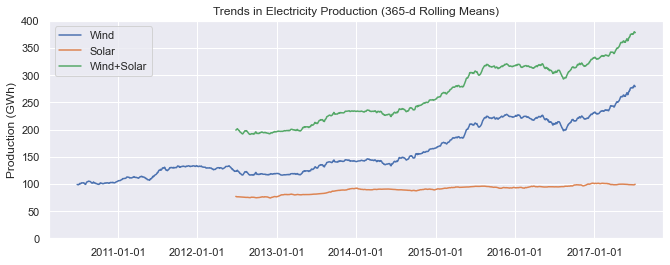

In [52]:
# Plot 365-day rolling mean time series of wind and solar power
fig, ax = plt.subplots()
for nm in ['Wind', 'Solar', 'Wind+Solar']:
    ax.plot(opsd_365d[nm], label=nm)
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_ylim(0, 400)
    ax.legend()
    ax.set_ylabel('Production (GWh)')
    ax.set_title('Trends in Electricity Production (365-d Rolling Means)')

We can see a small increasing trend in solar power production and a large increasing trend in wind power production, as Germany continues to expand its capacity in those sectors.

# Summary and further reading
We’ve learned how to wrangle, analyze, and visualize our time series data in pandas using techniques such as time-based indexing, resampling, and rolling windows. Applying these techniques to our OPSD data set, we’ve gained insights on seasonality, trends, and other interesting features of electricity consumption and production in Germany.

Other potentially useful topics we haven’t covered include time zone handling and time shifts. If you’d like to learn more about working with time series data in pandas, you can check out this section of the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html), [this blog post](https://tomaugspurger.github.io/modern-7-timeseries), and of course the official documentation.

# References
- [Dataquest Tutorial](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)